This Jupyter Notebook is meant as a supplement for the NeurIPS 2021 [paper](https://proceedings.neurips.cc/paper/2021/file/464074179972cbbd75a39abc6954cd12-Paper.pdf), ***Low-Dimensional Structure in the Space of Language Representations Is Reflected In Brain Responses***. It requires data which can be downloaded from Figshare [here](https://figshare.com/articles/dataset/Language_Representation_Embedding_Data_for_the_paper_Low-Dimensional_Structure_in_the_Space_of_Language_Representations_is_Reflected_in_Brain_Responses_/17141915). Please place this data in the same directory as this notebook. We start by importing relevant libaries in this first cell.

In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import linalg as LA
from IPython.display import Image
import warnings
from pretty_print import pretty_print_mat, pretty_print_mds

warnings.simplefilter('ignore')
%matplotlib inline

In our paper, we generated a set of "language representation embeddings" from the transfer properties of each of 100 different language representations. We have provided some initial precomputed values for use with this notebook, as computing these independently is computationally expensive and burdensome to collate efficiently. We start with a matrix containing these transfer properties. The list labels identifies which representation each dimension correpsonds to in this matrix. Please see Appendix A of the paper for a full description of each of these representations. 

In [2]:
full_mat = joblib.load("transfer_properties.jbl")
labels = ["GLOVE", "BERT-E", "FLAIR", "POS", "CHUNK", "NER", "FRAME", "GLOVE_NWE",
         "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12", #GPT-2 Small
        "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "M10", "M11", "M12",  #GPT-2 Medium
        "M13", "M14", "M15", "M16", "M17", "M18", "M19", "M20", "M21", "M22", "M23", "M24",
        "XL1", "XL2", "XL3", "XL4", "XL5", "XL6", "XL7", "XL8", "XL9", #Transformer-XL
        "XL10", "XL11", "XL12", "XL13", "XL14", "XL15", "XL16", "XL17", "XL18",
        "B0", "B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B10", "B11", "B12", #BERT
         "A0", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", #ALBERT
        "MTEZ1", "MTEZ2", "MTEZ3", "MTEZ4", "MTEZ5", "MTEZ6", # English -> Chinese
        "MTEG1", "MTEG2", "MTEG3", "MTEG4", "MTEG5", "MTEG6", # English -> German 
        ]
num_tasks = len(labels)
print("Dimensions of Matrix: " + str(full_mat.shape) + "\nNumber of Labels: " + str(num_tasks))

Dimensions of Matrix: (100, 100, 1839)
Number of Labels: 100


Element $(i,j)$ of the matrix ```full_mat``` holds a 1839-element vector of mean squared error values of the performance of using the latent space for representation $i$ to decode to representation $j$ on a natural language test set. This matrix will be used to generate our pairwise tournament matrix, which will subequently be used to generate our language representation embeddings. Let's generate the tournament matrix now. This may take a few minutes. If you would like to skip this step, you may do so by uncommenting the cell that loads the tournament matrix directly.

In [3]:
transferability = [] # will contain our pairwise matrices
num_tasks = len(labels)
for t in range(num_tasks):
    print("Generating Pairwise Matrix for representation: " + labels[t])
    pairwise = np.zeros((num_tasks,num_tasks)) # Initialize pairwise matrix
    for s_i in range(num_tasks):
        for s_j in range(num_tasks):
            if s_i != s_j:
                better = 0
                worse = 0
                for ei, k in enumerate(full_mat[t][s_i]):
                    if full_mat[t][s_i][ei] > full_mat[t][s_j][ei]: # Compare performance of decoders s_i & s_j
                        better += 1
                    else:
                        worse += 1
                pairwise[s_i][s_j] = better / (worse + 0.0001) # Edge case in case worse == 0
                if t == s_j: # Zero out main diagonal for affinity computation so it doesn't dominate
                    pairwise[s_i][s_j] = 0.0001
    transferability.append(pairwise)

Generating Pairwise Matrix for representation: GLOVE
Generating Pairwise Matrix for representation: BERT-E
Generating Pairwise Matrix for representation: FLAIR
Generating Pairwise Matrix for representation: POS
Generating Pairwise Matrix for representation: CHUNK
Generating Pairwise Matrix for representation: NER
Generating Pairwise Matrix for representation: FRAME
Generating Pairwise Matrix for representation: GLOVE_NWE
Generating Pairwise Matrix for representation: S1
Generating Pairwise Matrix for representation: S2
Generating Pairwise Matrix for representation: S3
Generating Pairwise Matrix for representation: S4
Generating Pairwise Matrix for representation: S5
Generating Pairwise Matrix for representation: S6
Generating Pairwise Matrix for representation: S7
Generating Pairwise Matrix for representation: S8
Generating Pairwise Matrix for representation: S9
Generating Pairwise Matrix for representation: S10
Generating Pairwise Matrix for representation: S11
Generating Pairwise Mat

In [ ]:
#transferability = joblib.load("transferability.jbl") # Uncomment to load tournament matrix directly.

Our next step is to convert the pairwise matrix to representation embeddings. We do this by using the principal eigenvector of the pairwise matrices to estimate a total order over each, effectively ranking how well each representation transfers to each other representation. We also perform normalization steps to ensure each row sums to (approximately) 1 and the main diagonal is consistent across representations. We say "approximately" because fixing the main diagonal permits the sum across rows to slightly deviate from 1.

In [4]:
affinity = np.zeros((num_tasks,num_tasks))
for ei, i in enumerate(transferability):
    pairs = i.T
    norms = norm(pairs, axis=0, ord=1)
    normed_pairwise = np.zeros((num_tasks,num_tasks))
    for i in range(len(pairs)):
        normed_pairwise[i] = pairs[i] / norms[i] # Normalize the pairwise matrix
    S, U = LA.eig(normed_pairwise) # Compute principal eigenvectors
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat) # Remove imaginary components
    affinity[ei] = stationary / np.sum(stationary) # Renormalize
for ei in range(len(affinity)):
    affinity[ei][ei] = 0.1 # Re-add main diagonal

At this point, we have the language representation embedding matrix stored in ```affinity```, so lets see what it looks like! Here we pretty print the matrix as in the paper for easy visualization.

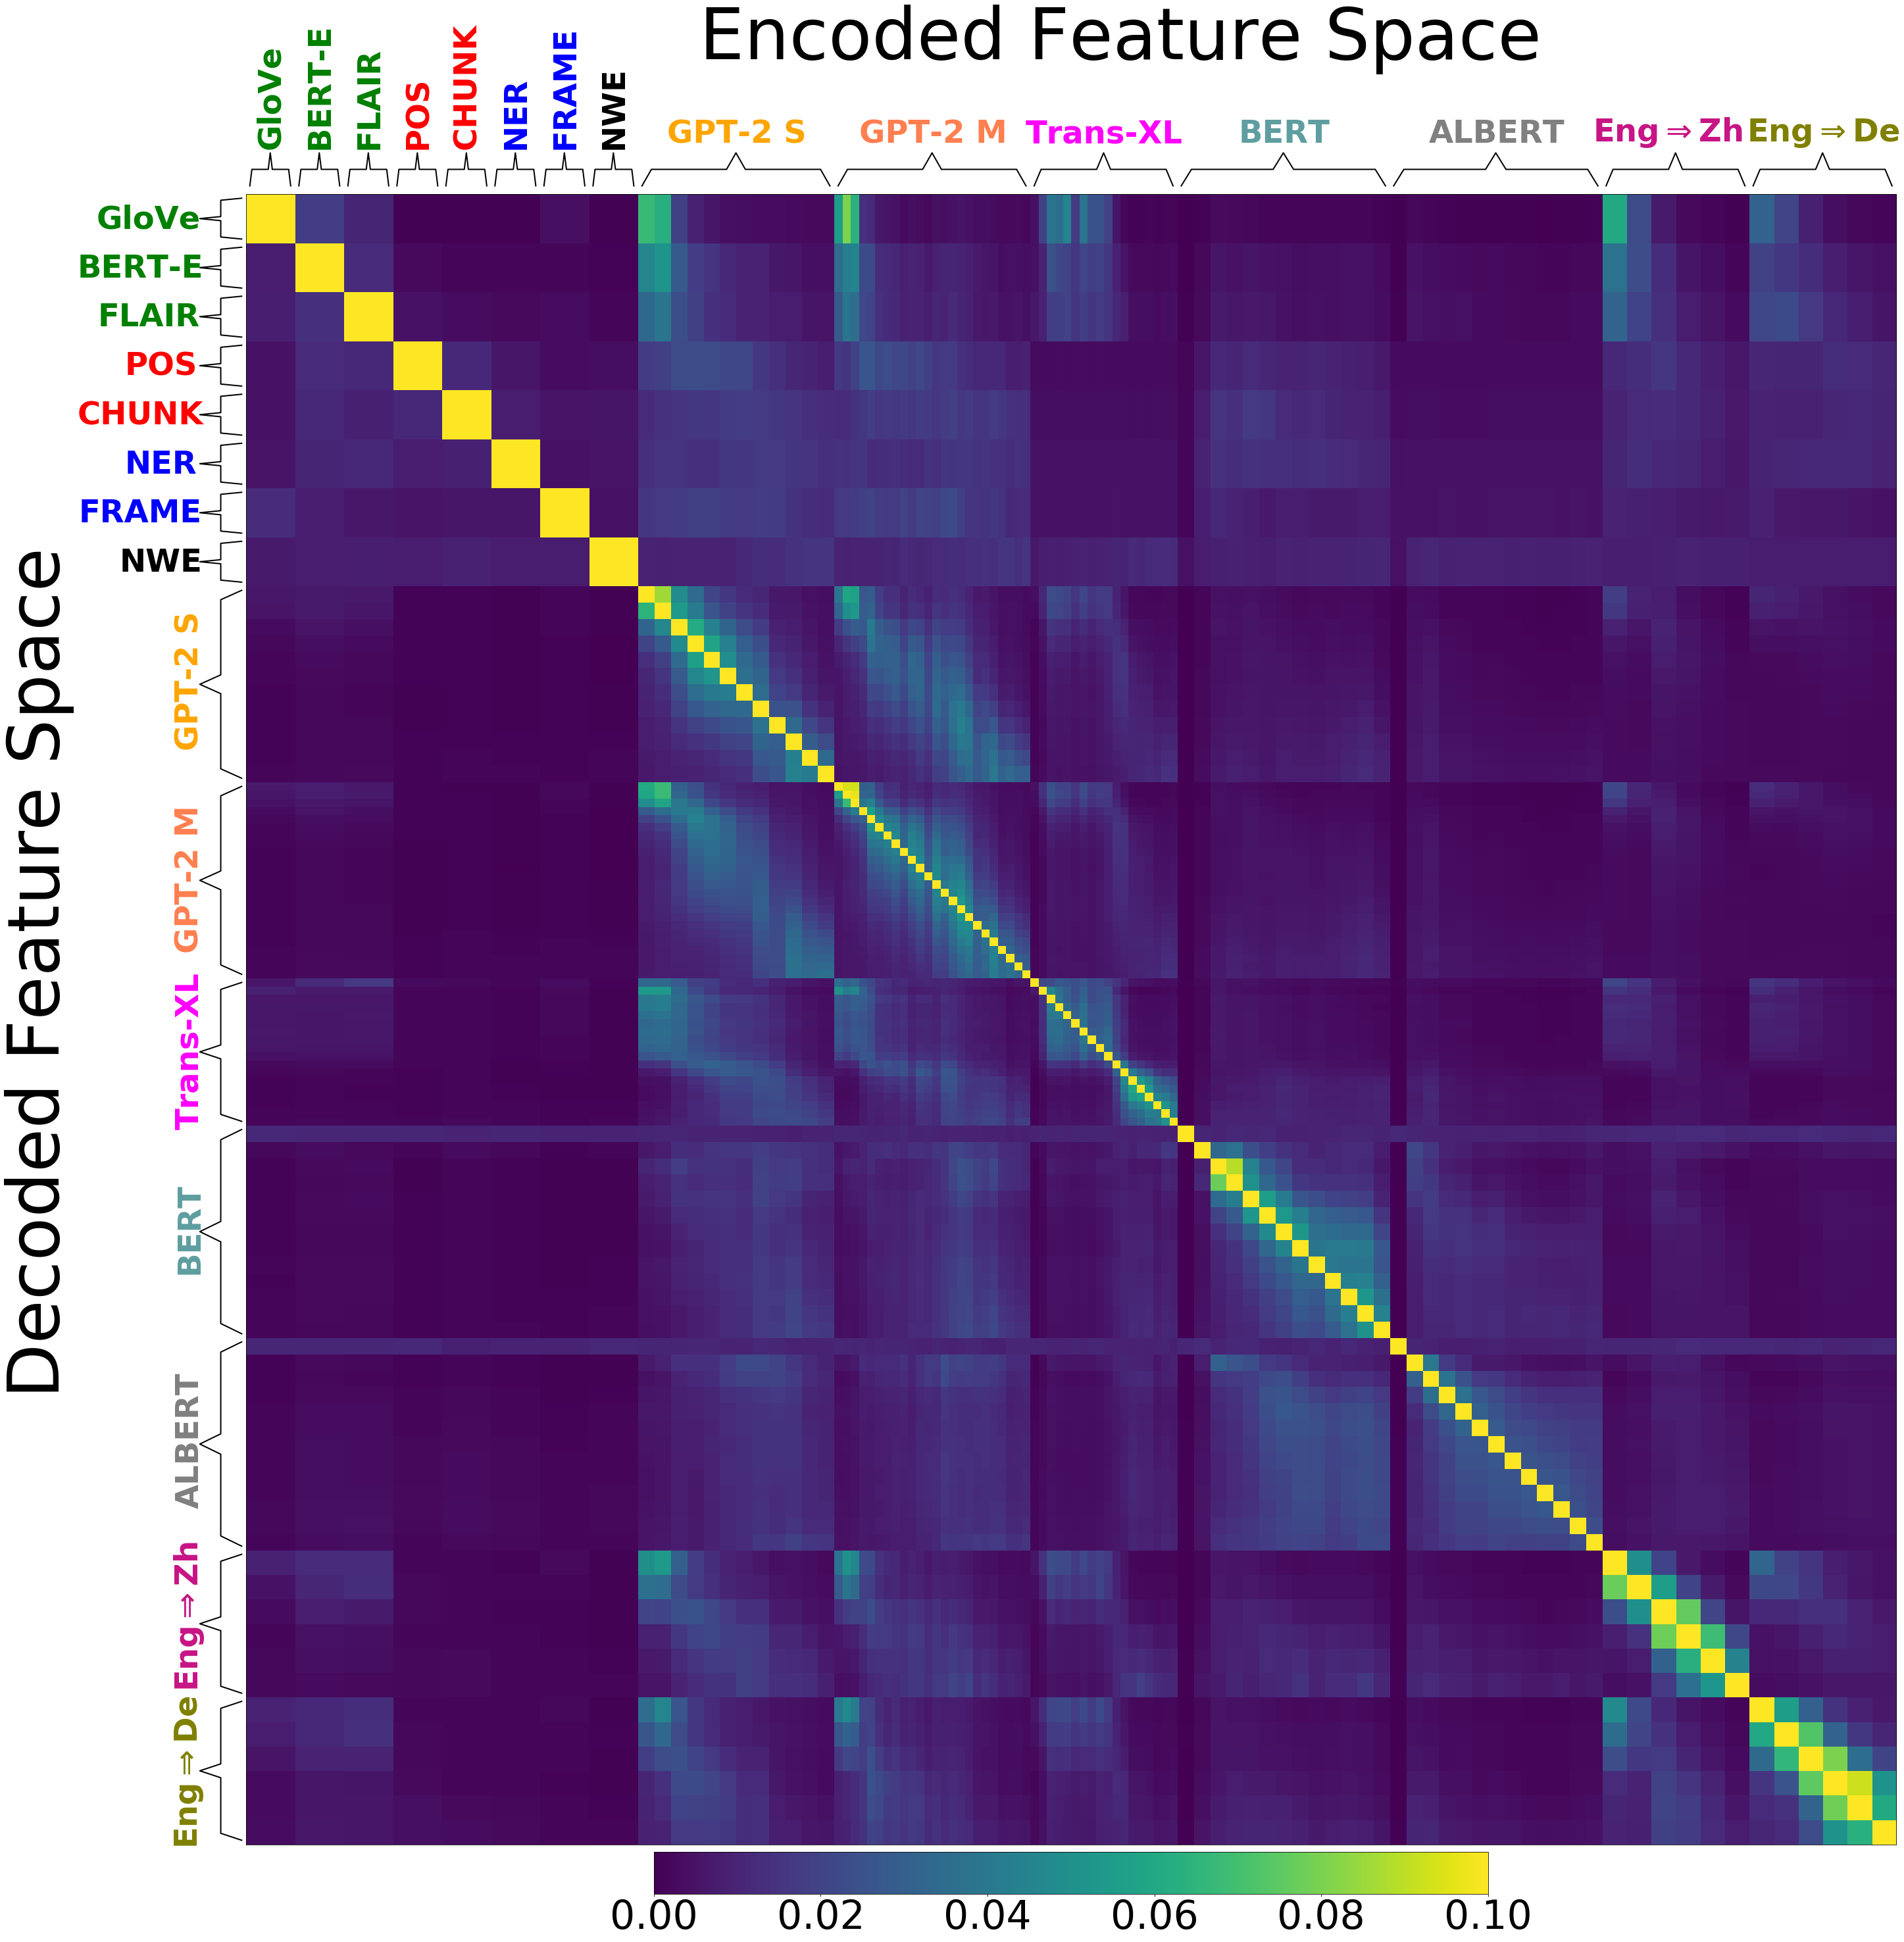

In [5]:
pretty_print_mat(affinity)

We see many interesting features here, many of which are described in the paper. Let's see what happens if we perform dimensionality reduction on this embedding space. Here we use weighted MDS, normalizing so that each feature space has equal effect on the resultant space.

In [6]:
multiplicands = [72] * 8 + [6] * 12 + [3] * 24 + [4] * 18 + [6] * 13 + [6] * 13 + [12] * 6 + [12] * 6 
new_rel = []
for ei, i in enumerate(affinity):
    new_rel += multiplicands[ei] * [i]
new_rel = np.array(new_rel)
corrdist = 1 - np.corrcoef(new_rel)

# Perform

n = corrdist.shape[0]
C = np.eye(n)- np.ones(n)/n # centering matrix
B = -0.5 * C.dot(corrdist).dot(C)

l1, q1 = np.linalg.eigh(B)

q1[:,-1] *= np.sign(q1[12,-1]) # make sure sign is consistent
q1[:,-2] *= np.sign(q1[12,-2]) # make sure sign is consistent
q1[:,-3] *= np.sign(q1[12,-3]) # make sure sign is consistent
final_q1 = []
acc = 0
for i in multiplicands: #Extract low-d points for each representation
    final_q1.append(q1[acc])
    acc += i
q1 = np.array(final_q1)

We now have everything we need to pretty print our representation embedding structure, but first let's check if the structure is low-dimensional by looking at the eigenvectors of MDS analysis in a quick skree plot:

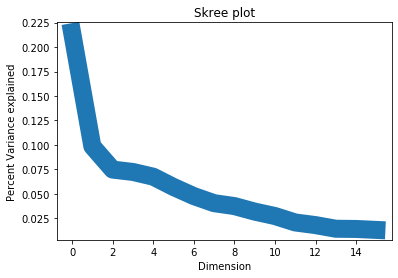

In [7]:
top_20 = list(l1[-20:])
top_20.reverse()
plt.title("Skree plot")
plt.xlabel("Dimension")
plt.ylabel("Percent Variance explained")
plt.plot(range(len(l1[-16:])), top_20[:16]/l1.sum(), lw=18) # Normalize and plot eigenvalues

Looks pretty low-dimensional! So let's finish up by actually plotting this low-dimensional mapping of the language representation embedding space. Note that this uses the ```imagemagick``` writer to generate this final gif.

Writing gif...


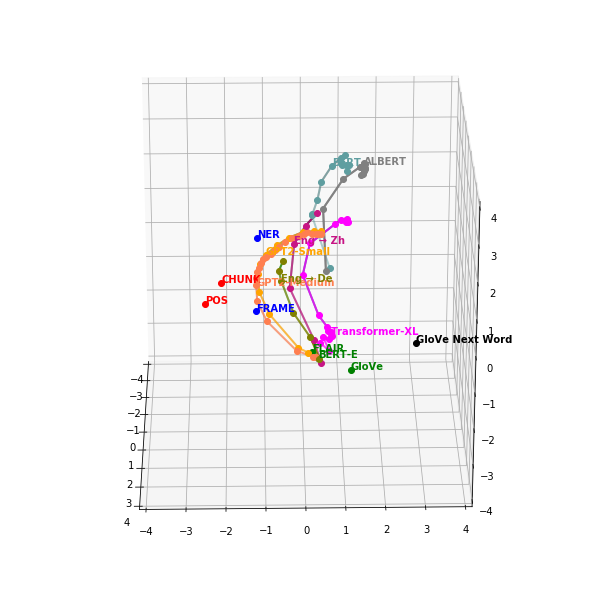

In [8]:
pretty_print_mds(q1, l1, fname="mds_lre.gif", writer="imagemagick")

Image(url="mds_lre.gif") 

We see a lot of structure here, especially along the principal axis and in the clustering of related representations such as word embedding spaces and unidirectional language models. This concludes Part 1 of the demonstration code for our paper. We are preparingto release Part 2, which covers the encoding models and along with all the representation data, as part of an upcoming compendium of encoding model results. Stay tuned!

If you have questions or comments about this notebook, please send them to rjantonello AT utexas DOT edu.